In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DF=pd.read_csv('OnlineRetailData.csv')

DF.info()
DF.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
DF = DF[~DF['InvoiceNo'].astype(str).str.startswith('C')]
DF['InvoiceDate'] = pd.to_datetime(DF['InvoiceDate'])


In [8]:
last_date = DF['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = DF.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'MonetaryValue'})

# Check the first few rows
print(rfm.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          1           1.04
12347.0           2        182         481.21
12348.0          75         31         178.71
12349.0          19         73         605.10
12350.0         310         17          65.30


In [9]:
DF = DF.dropna(subset=['CustomerID'])

In [31]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_


print(rfm['Cluster'].value_counts())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
3    1282
4    1036
0    1021
1     744
5     252
2       4
Name: count, dtype: int64


           CustomerID   Recency    Frequency  MonetaryValue
Cluster                                                    
0        15298.229187  1.402742    75.161606     218.105173
1        14829.315860  9.125045    25.672043      91.984034
2        14899.000000  0.016667  5807.750000   22893.065000
3        17146.011700  2.573713    57.503120     168.443378
4        13283.715251  1.471911    75.589768     239.763746
5        15600.043651  0.483862   503.265873    1559.393651


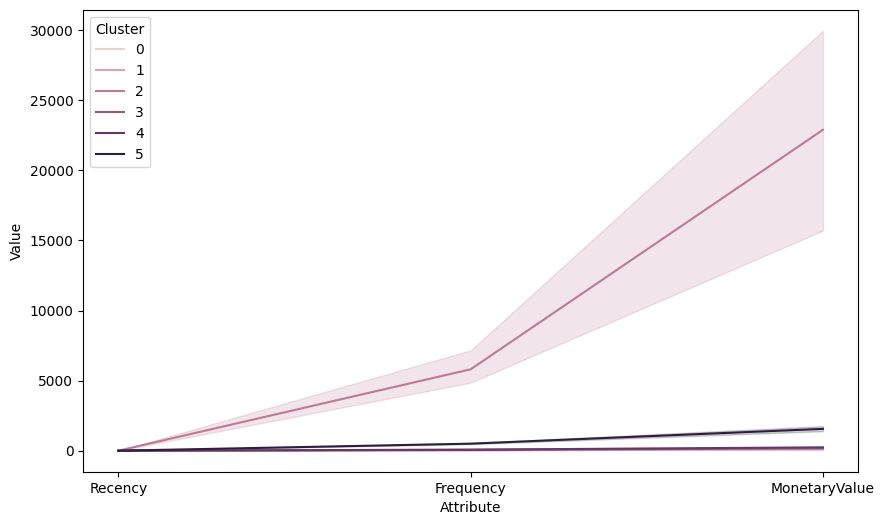

In [32]:
# Calculate the mean RFM values for each cluster
cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)

# Visualize the clusters
rfm_melted = pd.melt(rfm.reset_index(), id_vars=['CustomerID', 'Cluster'], value_vars=['Recency', 'Frequency', 'MonetaryValue'], var_name='Attribute', value_name='Value')
plt.figure(figsize=(10, 6))
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfm_melted)
plt.show()

In [17]:

last_date = datetime(2011, 12, 9)


rfm = DF.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: ((last_date - x.max()).days) / 30),
    Frequency=('InvoiceNo', 'count'),
    MonetaryValue=('UnitPrice', 'sum')  
).reset_index()

# Calculate IQR for Frequency and MonetaryValue
Q1 = rfm[['Frequency', 'MonetaryValue']].quantile(0.25)
Q3 = rfm[['Frequency', 'MonetaryValue']].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
is_not_outlier = ~((rfm[['Frequency', 'MonetaryValue']] < (Q1 - 1.5 * IQR)) | (rfm[['Frequency', 'MonetaryValue']] > (Q3 + 1.5 * IQR))).any(axis=1)
rfm_filtered = rfm[is_not_outlier]

# Normalize the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'MonetaryValue_scaled'])


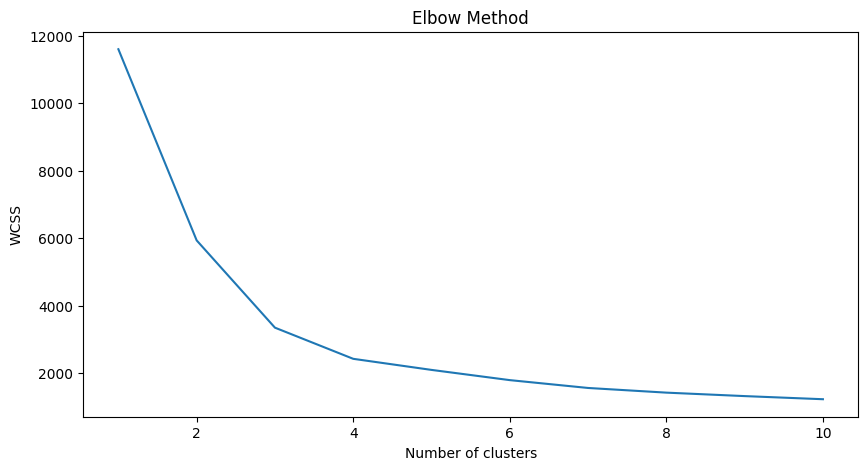

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


rfm_scaled = rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'MonetaryValue_scaled']].to_numpy()

# Calculating WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results on a line graph to observe the 'Elbow'
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


Number of clusters: 2, Silhouette Score: 0.47
Number of clusters: 3, Silhouette Score: 0.47
Number of clusters: 4, Silhouette Score: 0.44
Number of clusters: 5, Silhouette Score: 0.38
Number of clusters: 6, Silhouette Score: 0.36
Number of clusters: 7, Silhouette Score: 0.37
Number of clusters: 8, Silhouette Score: 0.34
Number of clusters: 9, Silhouette Score: 0.33
Number of clusters: 10, Silhouette Score: 0.32


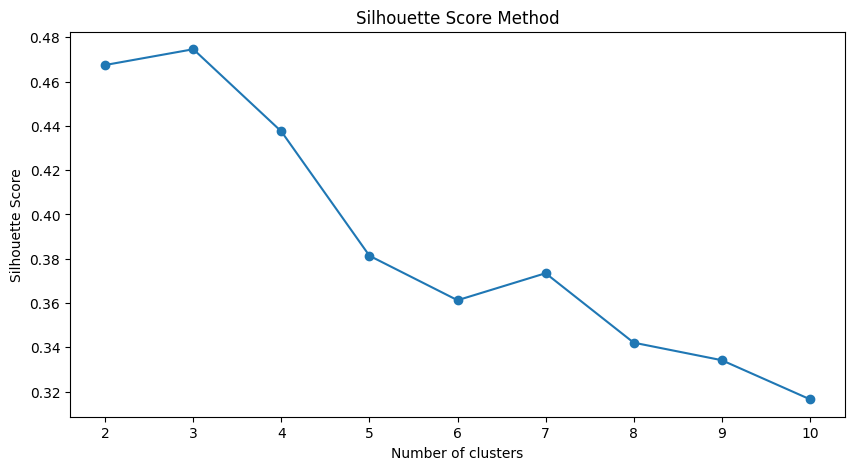

In [19]:
from sklearn.metrics import silhouette_score

# Silhouette score calculation
silhouette_scores = []
for i in range(2, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"Number of clusters: {i}, Silhouette Score: {score:.2f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [24]:

optimal_clusters = 2


kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(rfm_scaled)


rfm_filtered['Cluster'] = cluster_labels


print(rfm_filtered['Cluster'].value_counts())


centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Recency', 'Frequency', 'MonetaryValue'])
print(centroids)


Cluster
0    2783
1    1083
Name: count, dtype: int64
    Recency   Frequency  MonetaryValue
0  4.068608   26.776420      81.438934
1  1.352829  114.849631     335.930776


/var/folders/ym/0_vtz1kx4_5fl0q9222rj5n40000gn/T/ipykernel_17759/3990554781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_filtered['Cluster'] = cluster_labels


Number of clusters: 2, WCSS: 5934.96, Silhouette Score: 0.47
Number of clusters: 3, WCSS: 3349.67, Silhouette Score: 0.47
Number of clusters: 4, WCSS: 2426.73, Silhouette Score: 0.44
Number of clusters: 5, WCSS: 2098.40, Silhouette Score: 0.38
Number of clusters: 6, WCSS: 1795.46, Silhouette Score: 0.36
Number of clusters: 7, WCSS: 1563.32, Silhouette Score: 0.37
Number of clusters: 8, WCSS: 1425.00, Silhouette Score: 0.34
Number of clusters: 9, WCSS: 1322.38, Silhouette Score: 0.33
Number of clusters: 10, WCSS: 1229.91, Silhouette Score: 0.32


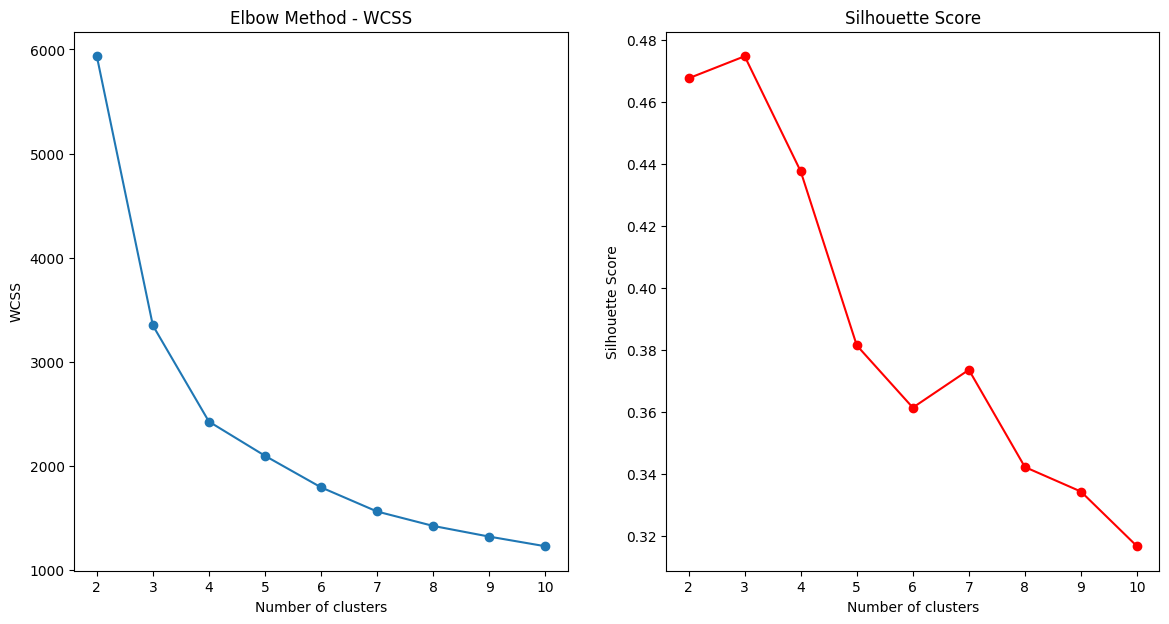

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
silhouette_scores = []
for i in range(2, 11): 
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {i}, WCSS: {kmeans.inertia_:.2f}, Silhouette Score: {silhouette_avg:.2f}")

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method - WCSS')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


Clusters: 2, Silhouette Score: 0.73
Clusters: 3, Silhouette Score: 0.65
Clusters: 4, Silhouette Score: 0.58
Clusters: 5, Silhouette Score: 0.58
Clusters: 6, Silhouette Score: 0.57
Clusters: 7, Silhouette Score: 0.57
Clusters: 8, Silhouette Score: 0.49
Clusters: 9, Silhouette Score: 0.49
Clusters: 10, Silhouette Score: 0.48


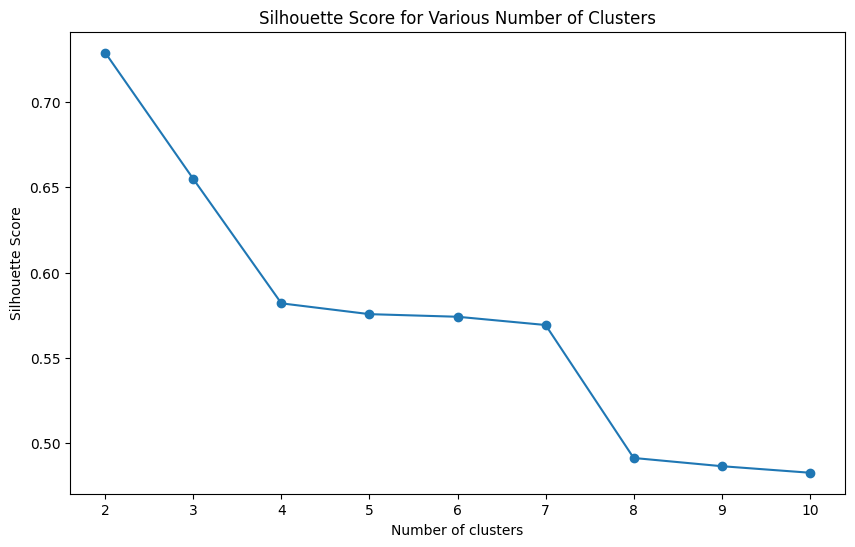

Optimal Number of Clusters: 2
New Silhouette Score with Optimal Clusters: 0.73


In [33]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np




scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])


silhouette_scores = []
for i in range(2, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, clusters)
    silhouette_scores.append(score)
    print(f"Clusters: {i}, Silhouette Score: {score:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various Number of Clusters')
plt.show()


optimal_clusters = np.argmax(silhouette_scores) + 2  
print(f"Optimal Number of Clusters: {optimal_clusters}")

# Re-run K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Calculate new silhouette score with the optimal number of clusters
new_silhouette_score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"New Silhouette Score with Optimal Clusters: {new_silhouette_score:.2f}")


In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Finding the optimal number of clusters using silhouette score with GMM
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm_clusters = gmm.fit_predict(rfm_pca)
    score = silhouette_score(rfm_pca, gmm_clusters)
    print(f"Clusters: {i}, Silhouette Score: {score:.2f}")



# Apply GMM with the chosen number of components
optimal_n_components = 4  
gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='tied', n_init=5, random_state=42)
rfm['Cluster_GMM'] = gmm.fit_predict(rfm_pca)

# Recalculate silhouette score
score_gmm = silhouette_score(rfm_pca, rfm['Cluster_GMM'])
print(f"Adjusted GMM Silhouette Score: {score_gmm:.2f}")


# Evaluate with silhouette score
score_gmm = silhouette_score(rfm_pca, rfm['Cluster_GMM'])
print(f"Silhouette Score with GMM: {score_gmm:.2f}")


Clusters: 2, Silhouette Score: -0.07
Clusters: 3, Silhouette Score: 0.30
Clusters: 4, Silhouette Score: 0.17
Clusters: 5, Silhouette Score: 0.13
Clusters: 6, Silhouette Score: -0.02
Clusters: 7, Silhouette Score: 0.11
Clusters: 8, Silhouette Score: -0.00
Clusters: 9, Silhouette Score: -0.02
Clusters: 10, Silhouette Score: -0.07
Adjusted GMM Silhouette Score: 0.59
Silhouette Score with GMM: 0.59


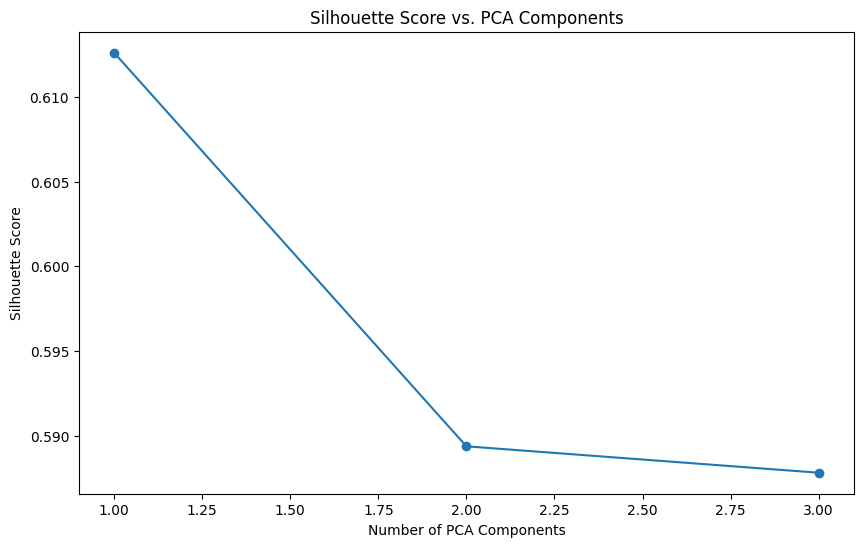

Silhouette Score with DBSCAN: 0.68


In [39]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


silhouette_scores_pca = {}
n_components_range = range(1, min(5, rfm_scaled.shape[1]+1))  
optimal_n_components = 4  

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    rfm_pca = pca.fit_transform(rfm_scaled)
    
    gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='tied', n_init=5, random_state=42)
    clusters = gmm.fit_predict(rfm_pca)
    score = silhouette_score(rfm_pca, clusters)
    silhouette_scores_pca[n_components] = score


plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores_pca.keys()), list(silhouette_scores_pca.values()), marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. PCA Components')
plt.show()






from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
X_std = StandardScaler().fit_transform(rfm_scaled)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_std)

# Assess clustering
if len(np.unique(clusters_dbscan)) > 1: 
    score_dbscan = silhouette_score(X_std, clusters_dbscan)
    print(f"Silhouette Score with DBSCAN: {score_dbscan:.2f}")
else:
    print("DBSCAN produced a single cluster or only noise.")




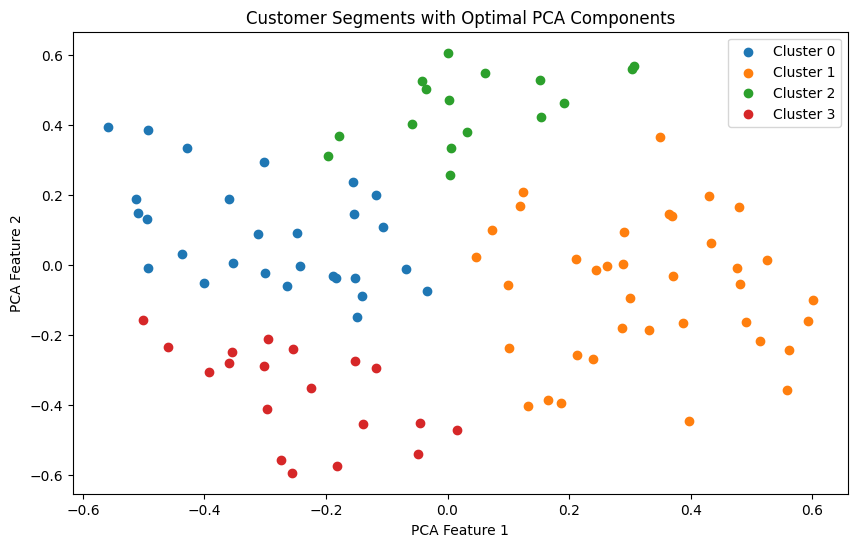

In [41]:

optimal_n_components = 2 

pca = PCA(n_components=optimal_n_components)
rfm_pca_optimal = pca.fit_transform(rfm_scaled)


gmm_optimal = GaussianMixture(n_components=4, random_state=42)  
clusters_optimal = gmm_optimal.fit_predict(rfm_pca_optimal)


plt.figure(figsize=(10, 6))
for i in range(max(clusters_optimal) + 1):
    plt.scatter(rfm_pca_optimal[clusters_optimal == i, 0], rfm_pca_optimal[clusters_optimal == i, 1], label=f'Cluster {i}')
plt.title('Customer Segments with Optimal PCA Components')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


In [42]:

np.random.seed(42)
rfm = pd.DataFrame({
    'Recency': np.random.randint(1, 100, size=100),
    'Frequency': np.random.randint(1, 20, size=100),
    'Monetary': np.random.randint(10, 1000, size=100)
})


rfm['Cluster'] = clusters_optimal  


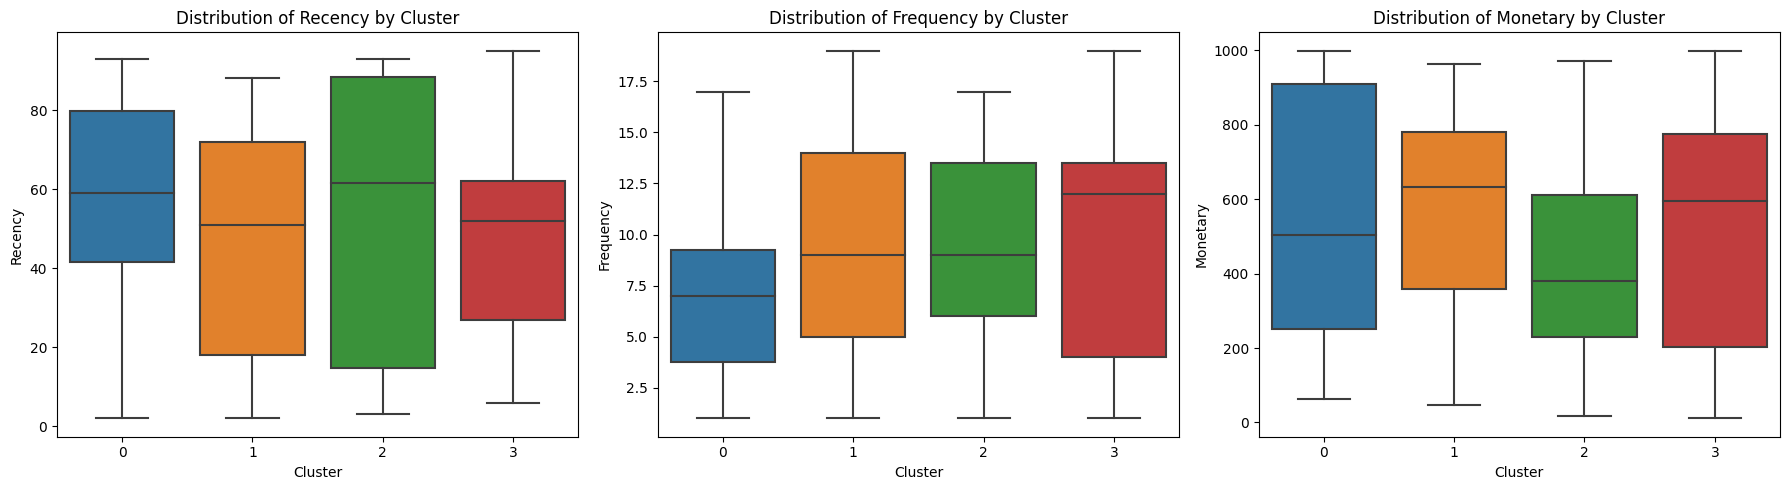

In [43]:
import seaborn as sns

plt.figure(figsize=(18, 5))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=rfm)
    plt.title(f'Distribution of {feature} by Cluster')

plt.tight_layout()
plt.show()


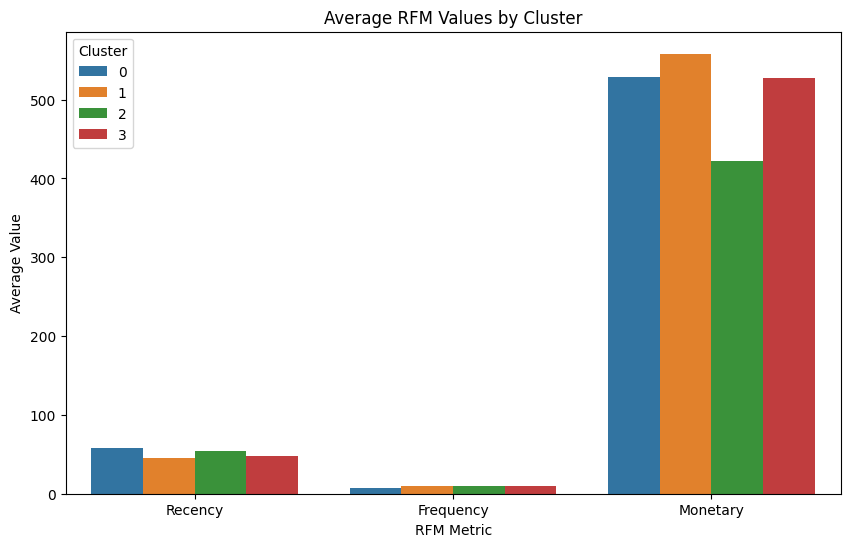

In [44]:
# Calculating average RFM values for each cluster
rfm_means = rfm.groupby('Cluster').mean().reset_index()

# Plotting the average RFM values by cluster
rfm_means_melted = pd.melt(rfm_means, id_vars=['Cluster'], value_vars=['Recency', 'Frequency', 'Monetary'])

plt.figure(figsize=(10, 6))
sns.barplot(x='variable', y='value', hue='Cluster', data=rfm_means_melted)
plt.title('Average RFM Values by Cluster')
plt.ylabel('Average Value')
plt.xlabel('RFM Metric')
plt.legend(title='Cluster')
plt.show()
